### Wrapping Up the labels

In this notebook, we are taking a deeper look at the labels within the categorical columns of product, subproduct, issue, and subissue. This is so that we can try to determine if there are any patterns or trends we can use to wrap the labels up to make them more cohesive and explainable. 

In [1]:
from google.cloud import bigquery
import pandas

In [2]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: ut-goog


### Reading in the data

Here we are reading in the above mentioned columns from the dataset. 

In [3]:
query = """
    SELECT 
        date_received,  
        product,  
        subproduct,   
        issue, subissue,   
        consumer_complaint_narrative,   
        company_public_response,  
        company_name, 
        state 
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

complaints_df = query_job.to_dataframe()
complaints_df.head()

,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state
0,2016-11-28,Prepaid card,General purpose card,Fees,None,I received a prepaid debit card from Citi bank...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",FL
1,2015-04-19,Prepaid card,ID prepaid card,Fees,None,XXXX/XXXX/15 purchased an American Express Blu...,None,AMERICAN EXPRESS COMPANY,CA
2,2015-09-25,Prepaid card,General purpose card,Fees,None,I received XXXX ( XXXX ) USBank Cash+ Bonus Re...,Company chooses not to provide a public response,U.S. BANCORP,CA
3,2015-09-26,Prepaid card,Gift or merchant card,Fees,None,I enrolled in American Express has premier shi...,None,AMERICAN EXPRESS COMPANY,CA
4,2017-04-01,Prepaid card,Other special purpose card,Fees,None,I received a {$50.00} American Express Prepaid...,None,AMERICAN EXPRESS COMPANY,OH


### Making datetime object

In [4]:
from datetime import datetime

In [5]:
complaints_df['date_received'] = pandas.to_datetime(complaints_df['date_received'])

In [6]:
complaints_df.set_index('date_received',inplace=True)

In [7]:
complaints_df.head()

,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state
date_received,,,,,,,,
2016-11-28,Prepaid card,General purpose card,Fees,None,I received a prepaid debit card from Citi bank...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",FL
2015-04-19,Prepaid card,ID prepaid card,Fees,None,XXXX/XXXX/15 purchased an American Express Blu...,None,AMERICAN EXPRESS COMPANY,CA
2015-09-25,Prepaid card,General purpose card,Fees,None,I received XXXX ( XXXX ) USBank Cash+ Bonus Re...,Company chooses not to provide a public response,U.S. BANCORP,CA
2015-09-26,Prepaid card,Gift or merchant card,Fees,None,I enrolled in American Express has premier shi...,None,AMERICAN EXPRESS COMPANY,CA
2017-04-01,Prepaid card,Other special purpose card,Fees,None,I received a {$50.00} American Express Prepaid...,None,AMERICAN EXPRESS COMPANY,OH


### 18 main products, 76 subproducts

In [8]:
print(complaints_df['product'].nunique())
print(complaints_df['subproduct'].nunique())

18
75


In [9]:
complaints_df['subproduct'].value_counts().sort_values()[:15]

Electronic Benefit Transfer / EBT card      3
Student prepaid card                        4
Transit card                               19
Traveler’s/Cashier’s checks                22
Credit repair                              39
Pawn loan                                  49
Check cashing                              54
Other special purpose card                 58
Government benefit payment card            80
Mobile wallet                              85
ID prepaid card                           101
Refund anticipation check                 104
Foreign currency exchange                 127
Cashing a check without an account        134
Check cashing service                     150
Name: subproduct, dtype: int64

Some of these subproducts are kinda weird and niche. Probably roll them into blanket subproducts. 

In [10]:
complaints_df.groupby([complaints_df['product']])['issue'].count().sort_values(ascending=False)

product
Credit reporting, credit repair services, or other personal consumer reports    161589
Debt collection                                                                 112624
Mortgage                                                                         64238
Credit card or prepaid card                                                      35622
Credit reporting                                                                 31588
Student loan                                                                     25914
Checking or savings account                                                      20932
Credit card                                                                      18838
Bank account or service                                                          14885
Consumer Loan                                                                     9473
Vehicle loan or lease                                                             8878
Money transfer, virtual currency, o

In [11]:
product_types = list(complaints_df['product'].unique())

Made a list of the different types of products to iterate through faster.

### See if products changed over time

In [12]:
year_grouping = complaints_df.groupby([complaints_df['product'],complaints_df.index.year])['issue'].count()
year_grouping

product                      date_received
Bank account or service      2015             4559
                             2016             7757
                             2017             2569
Checking or savings account  2017             4743
                             2018             6999
                                              ... 
Vehicle loan or lease        2019             2930
                             2020              632
Virtual currency             2015                7
                             2016                6
                             2017                3
Name: issue, Length: 69, dtype: int64

In [13]:
product_types

['Prepaid card',
 'Credit card',
 'Credit card or prepaid card',
 'Other financial service',
 'Money transfer, virtual currency, or money service',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Money transfers',
 'Student loan',
 'Payday loan, title loan, or personal loan',
 'Checking or savings account',
 'Payday loan',
 'Consumer Loan',
 'Virtual currency',
 'Mortgage',
 'Debt collection',
 'Vehicle loan or lease',
 'Bank account or service',
 'Credit reporting']

### Legend is a little overbearing so there is another plot below without it.

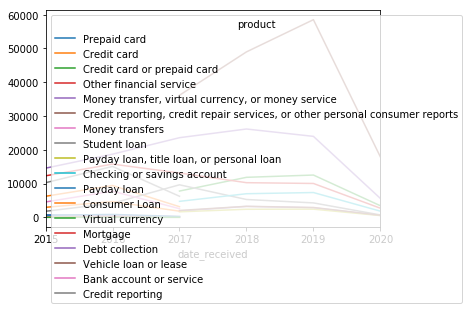

In [14]:
year_grouping.unstack(level=0)[product_types].plot()

In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


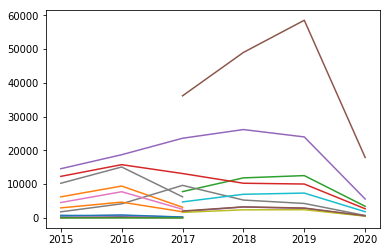

In [16]:
for product in product_types:
    plot(year_grouping.unstack(level=0).index, year_grouping.unstack(level=0)[product], marker='None', linestyle='-')

### Closer look at different products, note different scales.

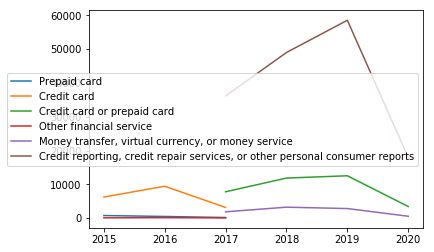

In [17]:
for product in product_types[:6]:
    plot(year_grouping.unstack(level=0).index, year_grouping.unstack(level=0)[product], marker='None', linestyle='-',label=product)
    legend(loc='best')

Looks like credit card went to prepaid/credit card

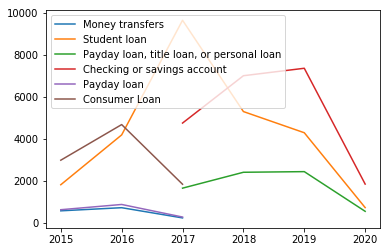

In [18]:
for product in product_types[6:12]:
    plot(year_grouping.unstack(level=0).index, year_grouping.unstack(level=0)[product], marker='None', linestyle='-',label=product)
    legend(loc='best')

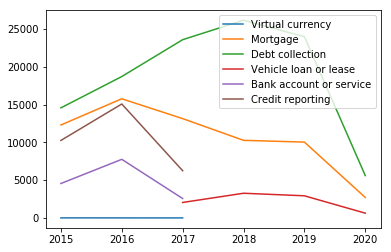

In [19]:
for product in product_types[12:]:
    plot(year_grouping.unstack(level=0).index, year_grouping.unstack(level=0)[product], marker='None', linestyle='-',label=product)
    legend(loc='best')

Looks like the product labels changed overtime. For example, Credit Card and Prepaid Card both end in 2017 but Credit Card or Prepaid Card picks up in 2017. This most likely reflects how the online submission form and options has changed from the CFPB's inception in 2011. This gives us a good, logical basis to wrap up the product labels.

### Looking at issues

In [20]:
complaints_df['issue'].nunique()

161

In [21]:
complaints_df['issue'].value_counts()[:20]

Incorrect information on your report                                                90397
Problem with a credit reporting company's investigation into an existing problem    43716
Attempts to collect debt not owed                                                   31786
Improper use of your report                                                         21688
Incorrect information on credit report                                              21217
Cont'd attempts collect debt not owed                                               17434
Trouble during payment process                                                      14836
Loan servicing, payments, escrow account                                            14722
Communication tactics                                                               14406
Written notification about debt                                                     13599
Managing an account                                                                 11355
False stat

In [22]:
sum(complaints_df['issue'].value_counts() < 1000)

96

A lot of the issue labels have less than a 1000 counts.

In [23]:
pandas.options.display.max_rows
pandas.set_option('display.max_rows', None)
complaints_df['issue'].value_counts().sort_values()[68:]

Credit line increase/decrease                                                         451
Other transaction issues                                                              471
Getting a loan                                                                        479
Unsolicited issuance of credit card                                                   491
Problem with a company's investigation into an existing issue                         499
Other fee                                                                             502
Credit determination                                                                  506
Trouble using the card                                                                507
Payoff process                                                                        513
Managing, opening, or closing your mobile wallet account                              525
Unauthorized transactions/trans. issues                                               543
Billing st

### Lets look at it from a percentage perspective.

In [24]:
issue_list = complaints_df['issue'].value_counts()/len(complaints_df)

In [25]:
issue_list.sort_values()

Lender damaged or destroyed property                                                0.000002
Property was damaged or destroyed property                                          0.000004
Problem with an overdraft                                                           0.000004
Lender damaged or destroyed vehicle                                                 0.000004
Lender sold the property                                                            0.000006
Property was sold                                                                   0.000008
Shopping for a line of credit                                                       0.000019
Disclosures                                                                         0.000025
Overdraft, savings, or rewards features                                             0.000029
Problem with overdraft                                                              0.000030
Managing the line of credit                                           

Note the Dealing with my lender or servicer is mentioned twice (should merge all of those together).

Check how many are less than 1 percent.

In [26]:
sum(issue_list < 0.01)

139

139 are less than 1 percent. I have a few noted that can be wrapped into bigger categories, but for the rest they should be wrapped up together as an "other" label.

### Looking at subproducts and subissues

In [27]:
complaints_df['subproduct'].nunique()

75

In [28]:
complaints_df['subproduct'].value_counts().sort_values()

Electronic Benefit Transfer / EBT card             3
Student prepaid card                               4
Transit card                                      19
Traveler’s/Cashier’s checks                       22
Credit repair                                     39
Pawn loan                                         49
Check cashing                                     54
Other special purpose card                        58
Government benefit payment card                   80
Mobile wallet                                     85
ID prepaid card                                  101
Refund anticipation check                        104
Foreign currency exchange                        127
Cashing a check without an account               134
Check cashing service                            150
Gift or merchant card                            154
Gift card                                        161
Traveler's check or cashier's check              165
Money order                                   

### Percentage Perspective

In [29]:
subproduct_list = complaints_df['subproduct'].value_counts()/len(complaints_df)

In [30]:
subproduct_list.sort_values()

Electronic Benefit Transfer / EBT card        0.000006
Student prepaid card                          0.000008
Transit card                                  0.000036
Traveler’s/Cashier’s checks                   0.000042
Credit repair                                 0.000074
Pawn loan                                     0.000093
Check cashing                                 0.000103
Other special purpose card                    0.000110
Government benefit payment card               0.000152
Mobile wallet                                 0.000162
ID prepaid card                               0.000192
Refund anticipation check                     0.000198
Foreign currency exchange                     0.000242
Cashing a check without an account            0.000255
Check cashing service                         0.000286
Gift or merchant card                         0.000293
Gift card                                     0.000307
Traveler's check or cashier's check           0.000314
Money orde

How many below 1 percent again.

In [31]:
sum(subproduct_list < 0.01)

57

Should follow the same recommendation as the products branch and merge the obvious labels like Gift Card and Gift and Merchant Card, while the rest get wrapped up into an "Other" label.

# Subissue

In [32]:
complaints_df['subissue'].nunique()

216

In [33]:
complaints_df['subissue'].value_counts().sort_values()

Was signed up for overdraft on card, but don't want to be                                    3
Trouble using the card to send money to another person                                       3
Problem with a check written from your prepaid card account                                  7
Qualified for a better loan than the one offered                                             8
Threatened to turn you in to immigration or deport you                                       9
Don't want a card provided by your employer or the government                               13
Overcharged for a purchase or transfer you did make with the card                           15
Overdraft charges                                                                           15
Changes in terms from what was offered or advertised                                        19
Problem with renewal                                                                        19
Problem with fees or penalties                    

In [34]:
subissue_list = complaints_df['subissue'].value_counts()/len(complaints_df)

In [35]:
subissue_list.sort_values()

Was signed up for overdraft on card, but don't want to be                                0.000006
Trouble using the card to send money to another person                                   0.000006
Problem with a check written from your prepaid card account                              0.000013
Qualified for a better loan than the one offered                                         0.000015
Threatened to turn you in to immigration or deport you                                   0.000017
Don't want a card provided by your employer or the government                            0.000025
Overcharged for a purchase or transfer you did make with the card                        0.000029
Overdraft charges                                                                        0.000029
Changes in terms from what was offered or advertised                                     0.000036
Problem with renewal                                                                     0.000036
Problem with fees or

In [36]:
sum(subissue_list < 0.01)

201

Subissues should follow the same logic as subproducts and issues. That is, we should wrap up labels that are less than 1 percent into an other category, while wrapping up obvious labels like Account status and Account status incorrect. 